In [1]:
import pandas as pd
import random
import numpy as np
import math
import seaborn as sns
from datetime import date
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import six
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

In [2]:
data = pd.read_csv('HMXPC13_DI_v2_5-14-14.csv')

In [3]:
data = data.drop(['roles', 'incomplete_flag' , 'registered', 'certified'], axis=1) #We are dropping 3 columns: registered becasue it has only
#value 1 and nothing else; incoplete flag and roles because they have mostly Null values and are only used for administration

In [4]:
data.shape

(641138, 16)

#### Considering that all 4 tested columns have no value 0 we will now assign 0 to all rows that have NaN value

In [5]:
data['nevents'].fillna(0.0, inplace = True)

In [6]:
data['ndays_act'].fillna(0.0, inplace = True)

In [7]:
data['nplay_video'].fillna(0.0, inplace = True)

In [8]:
data['nchapters'].fillna(0.0, inplace = True)

#### Transforming Country of origin data using get_dummies function - Converts categorical variable into dummy/indicator variables

In [9]:
data = data.join(pd.get_dummies(data['final_cc_cname_DI']))

When the date is missing from the column "last_event_DI" this means that there was no interaction with the course after enrolment. Considering this we have decided to put starting date as the date of last interaction instead of NaN value. This way we keep all entries and we get 0 days active.

In [10]:
data["last_event_DI"] = data.apply(lambda x: x.start_time_DI if pd.isnull(x.last_event_DI) else x.last_event_DI, axis =1)

We have checked the type of all dates entered in columnes "start_time_DI" and "last_event_DI" and they are all String. The for loop that we used is removed from the code as it takes long time to run.
#### We now make a derivative columne that shows "monts active" and it is determined from start time of the course and last event
To work with dates, we need to convert them from strings into a data format built for processing dates. The pandas library comes with a Timestamp data object for storing and working with dates.

In [11]:
data["start_time_DI"] = pd.to_datetime(data["start_time_DI"] )

In [12]:
data["last_event_DI"] = pd.to_datetime(data["last_event_DI"] ) 

In [13]:
data['days_active'] = data['last_event_DI'] - data['start_time_DI']

In [14]:
data['days_active'] = data['days_active'].apply(lambda x: x.days)

#### Dealing with NaN values and transforming Year of birth so we can have new column "age"

In [15]:
#data['YoB'].fillna(int(data['YoB'].mean()), inplace = True) #for missing values we set mean of all ages - temporary solution

In [16]:
now = datetime.datetime.now()

#### Dealing with NaN values and converting Level of education from categorical variable into indicator variables

In [17]:
data['LoE_DI'] = data['LoE_DI'].fillna('UnknownLoE') #temporary solution

In [18]:
data['LoE_DI'].value_counts(dropna= False)

Bachelor's             219768
Secondary              169694
Master's               118189
UnknownLoE             106008
Less than Secondary     14092
Doctorate               13387
Name: LoE_DI, dtype: int64

In [19]:
data = data.join(pd.get_dummies(data['LoE_DI']))

#### Dealing with NaN values and converting Gender from categorical variable into indicator variables

In [20]:
data['gender'].value_counts(dropna= False)

m      411520
f      142795
NaN     86806
o          17
Name: gender, dtype: int64

In [21]:
data['gender'].fillna('u', inplace = True) #changing NaN values to 'u' -unknown - temporary solution

In [22]:
data = data.join(pd.get_dummies(data['gender']))

In [23]:
data = data.loc[data['grade'] != " ",] #some grades are empty string (space) and we drop those rows

In [24]:
data.dropna(axis=0, inplace=True) #only remaining NaN values are the once where there is a grade missing and we choose to drop

In [25]:
data['age'] = data['YoB'].apply(lambda x: now.year - int(x)) # we use provided year of birth to calculate
#age of all participants and save it as new column

In [26]:
data['grade'] = data['grade'].astype(float)

In [27]:
data.columns

Index(['course_id', 'userid_DI', 'viewed', 'explored', 'final_cc_cname_DI',
       'LoE_DI', 'YoB', 'gender', 'grade', 'start_time_DI', 'last_event_DI',
       'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts',
       'Australia', 'Bangladesh', 'Brazil', 'Canada', 'China', 'Colombia',
       'Egypt', 'France', 'Germany', 'Greece', 'India', 'Indonesia', 'Japan',
       'Mexico', 'Morocco', 'Nigeria', 'Other Africa', 'Other East Asia',
       'Other Europe', 'Other Middle East/Central Asia',
       'Other North & Central Amer., Caribbean', 'Other Oceania',
       'Other South America', 'Other South Asia', 'Pakistan', 'Philippines',
       'Poland', 'Portugal', 'Russian Federation', 'Spain', 'Ukraine',
       'United Kingdom', 'United States', 'Unknown/Other', 'days_active',
       'Bachelor's', 'Doctorate', 'Less than Secondary', 'Master's',
       'Secondary', 'UnknownLoE', 'f', 'm', 'o', 'u', 'age'],
      dtype='object')

In [28]:
d = data.drop(['course_id', 'userid_DI' , 'final_cc_cname_DI',
       'LoE_DI', 'YoB', 'start_time_DI', 'last_event_DI', 'o', 'u'], axis = 1)

In [29]:
d.shape 

(494790, 53)

In [30]:
comparison_columns = ['grade','age','gender','ndays_act', 'nevents', 'nplay_video','nchapters','nforum_posts','days_active','viewed','explored']

In [31]:
data[comparison_columns].corr()

,grade,age,ndays_act,nevents,nplay_video,nchapters,nforum_posts,days_active,viewed,explored
grade,1.000000,-0.006883,0.734289,0.708108,0.426550,0.699863,0.112328,0.336474,0.167548,0.692455
age,-0.006883,1.000000,0.014908,0.004322,0.007989,0.008195,-0.029792,0.006408,-0.019622,0.006762
ndays_act,0.734289,0.014908,1.000000,0.824735,0.555979,0.702574,0.144736,0.432399,0.238277,0.649746
nevents,0.708108,0.004322,0.824735,1.000000,0.735798,0.614646,0.131715,0.322178,0.183768,0.588577
nplay_video,0.426550,0.007989,0.555979,0.735798,1.000000,0.361502,0.080026,0.220107,0.124515,0.367265
nchapters,0.699863,0.008195,0.702574,0.614646,0.361502,1.000000,0.144426,0.438714,0.423771,0.789961
nforum_posts,0.112328,-0.029792,0.144736,0.131715,0.080026,0.144426,1.000000,0.072211,0.064617,0.097020
days_active,0.336474,0.006408,0.432399,0.322178,0.220107,0.438714,0.072211,1.000000,0.243235,0.391964
viewed,0.167548,-0.019622,0.238277,0.183768,0.124515,0.423771,0.064617,0.243235,1.000000,0.199247
explored,0.692455,0.006762,0.649746,0.588577,0.367265,0.789961,0.097020,0.391964,0.199247,1.000000


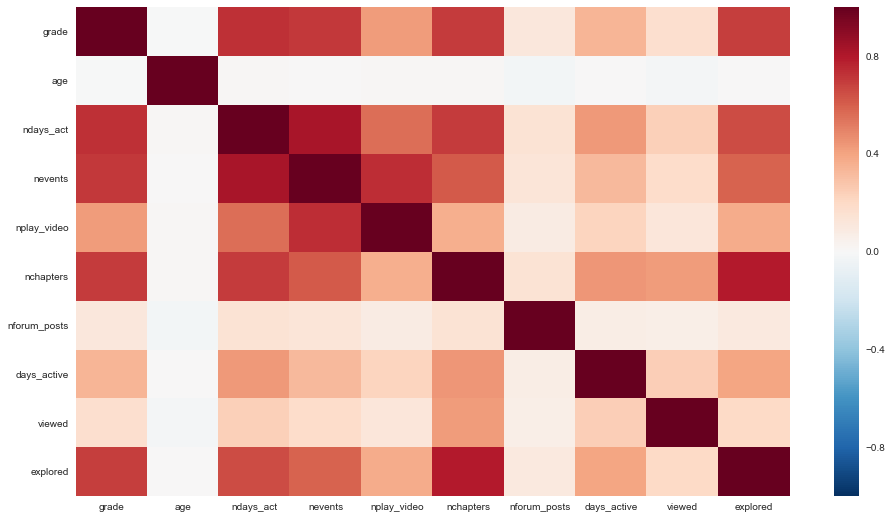

In [32]:
sns.heatmap(data[comparison_columns].corr())

# **Correlation between variables based on correlation table**

,Slope,Intercept,Correlation coeficient,Std_err
0,4.443109,143.056379,0.735798,0.005813


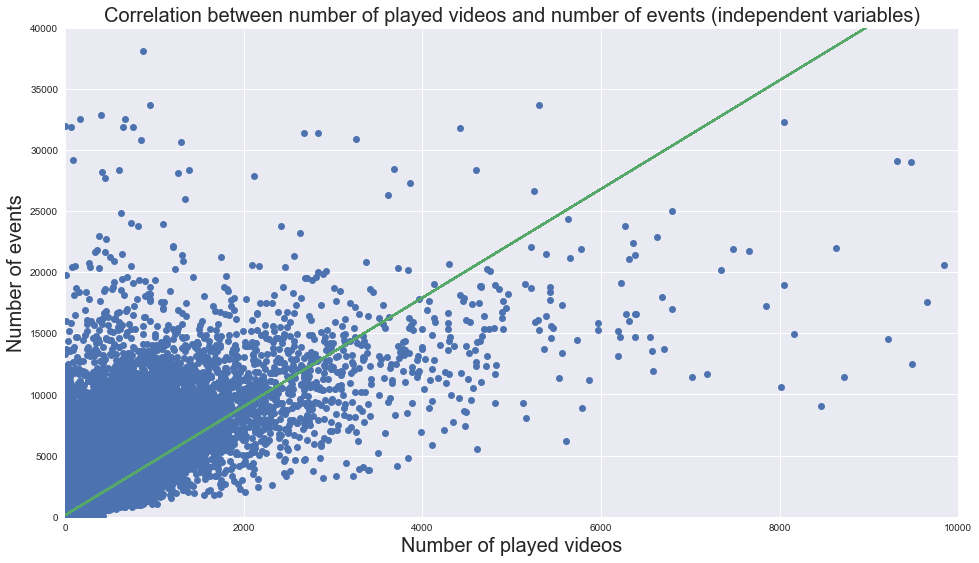

In [49]:
# plt.scatter(data['ndays_act'],data['nevents'])
plt.xlabel('Number of played videos', fontname = "Arial", fontsize=20)
plt.ylabel('Number of events', fontname = "Arial", fontsize=20)
plt.title('Correlation between number of played videos and number of events (independent variables)', fontname = "Arial", fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(data['nplay_video'],data['nevents'])
#p_r_value, p_p_value = stats.pearsonr(data['nplay_video'],data['nevents'])
line = slope* data['nplay_video']+intercept
axes = plt.gca()
axes.set_xlim([0,10000])
axes.set_ylim([0,40000])

plt.plot(data['nplay_video'],data['nevents'],'o', data['nplay_video'], line)
res = pd.DataFrame([[slope, intercept, r_value, std_err]], columns=['Slope', 'Intercept', 'Correlation coeficient', 'Std_err'])
res.head()

,slope,intercept,r_value,p_value,std_err
0,98.723039,-114.435066,0.824735,0.0,0.096237


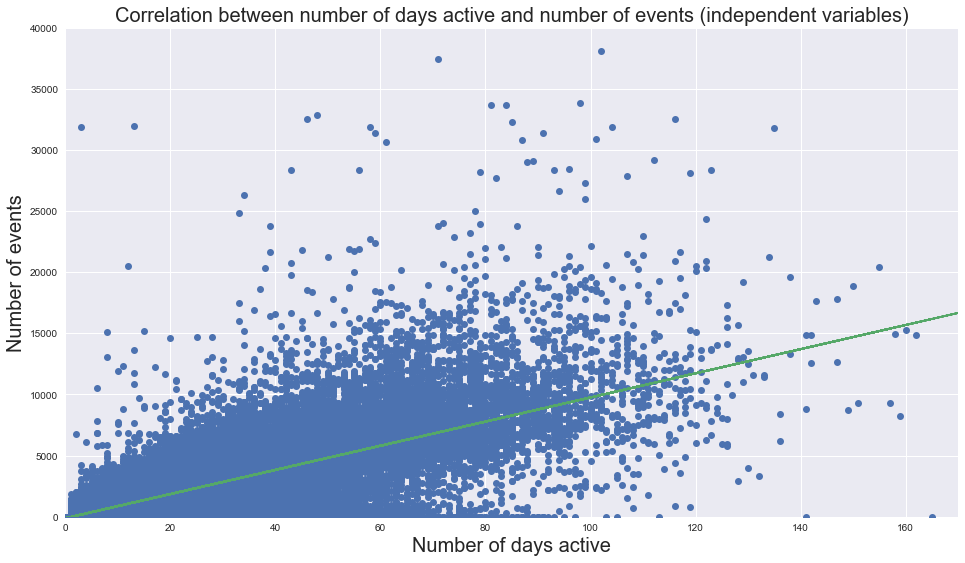

In [52]:
# plt.scatter(data['ndays_act'],data['nevents'])
plt.xlabel('Number of days active',  fontname = "Arial", fontsize=20)
plt.ylabel('Number of events',  fontname = "Arial", fontsize=20)
plt.title('Correlation between number of days active and number of events (independent variables)', fontname = "Arial", fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(data['ndays_act'],data['nevents'])
#p_r_value, p_p_value = stats.pearsonr(data['ndays_act'],data['nevents'])
line = slope* data['ndays_act']+intercept
axes = plt.gca()
axes.set_xlim([0,170])
axes.set_ylim([0,40000])

plt.plot(data['ndays_act'],data['nevents'],'o', data['ndays_act'], line)
res = pd.DataFrame([[slope, intercept, r_value, p_value, std_err]], columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err'])
res.head()

,slope,intercept,r_value,p_value,std_err,Pearsons r_value,Pearsons p_value
0,1.814629,0.180953,0.702574,0.0,0.002613,0.702574,0.0


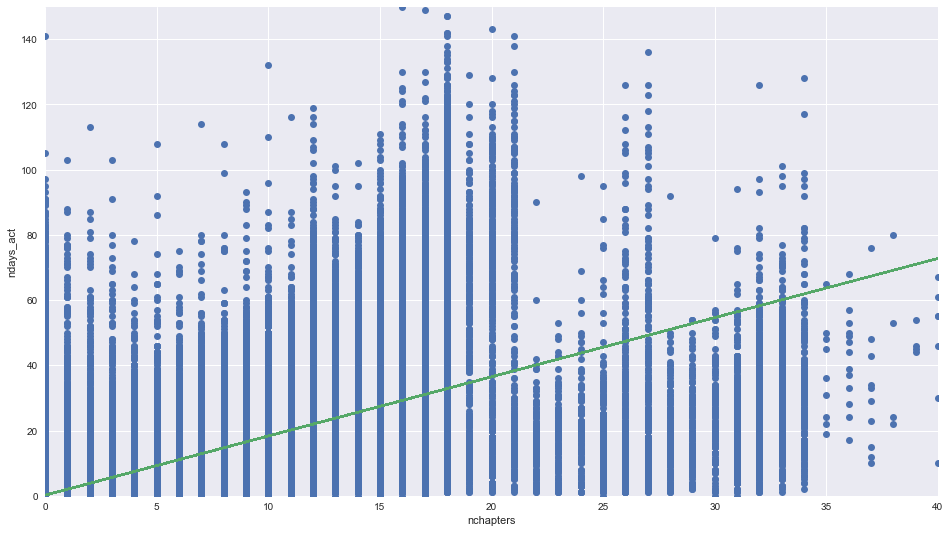

In [35]:
plt.xlabel('nchapters')
plt.ylabel('ndays_act')
slope, intercept, r_value, p_value, std_err = stats.linregress(data['nchapters'],data['ndays_act'])
p_r_value, p_p_value = stats.pearsonr(data['nchapters'],data['ndays_act'])
line = slope* data['nchapters']+intercept
axes = plt.gca()
axes.set_xlim([0,40])
axes.set_ylim([0, 150])

plt.plot(data['nchapters'],data['ndays_act'],'o', data['nchapters'], line)
res = pd.DataFrame([[slope, intercept, r_value, p_value, std_err, p_r_value, p_p_value]], columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err', 'Pearsons r_value','Pearsons p_value'])
res.head()

,slope,intercept,r_value,p_value,std_err,Pearsons r_value,Pearsons p_value
0,0.015772,-0.001536,0.649746,0.0,0.000026,0.649746,0.0


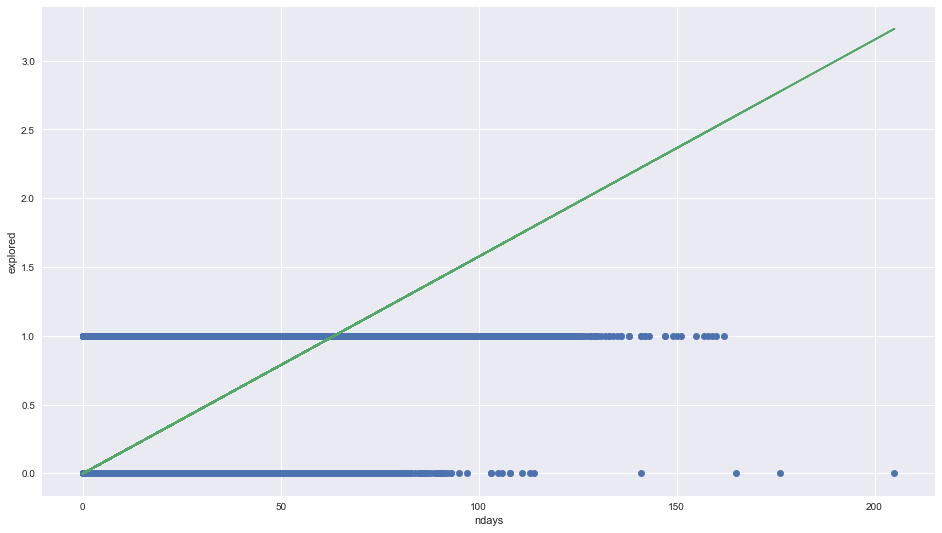

In [36]:
plt.xlabel('ndays')
plt.ylabel('explored')
slope, intercept, r_value, p_value, std_err = stats.linregress(data['ndays_act'],data['explored'])
p_r_value, p_p_value = stats.pearsonr(data['ndays_act'],data['explored'])
line = slope* data['ndays_act']+intercept
axes = plt.gca()
#axes.set_xlim([0,170])
#axes.set_ylim([0,40000])

plt.plot(data['ndays_act'],data['explored'],'o', data['ndays_act'], line)
res = pd.DataFrame([[slope, intercept, r_value, p_value, std_err, p_r_value, p_p_value]], columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err', 'Pearsons r_value','Pearsons p_value'])
res.head()

# Correlations with grade

,slope,intercept,r_value,p_value,std_err
0,0.010767,-0.011899,0.734289,0.0,0.000014


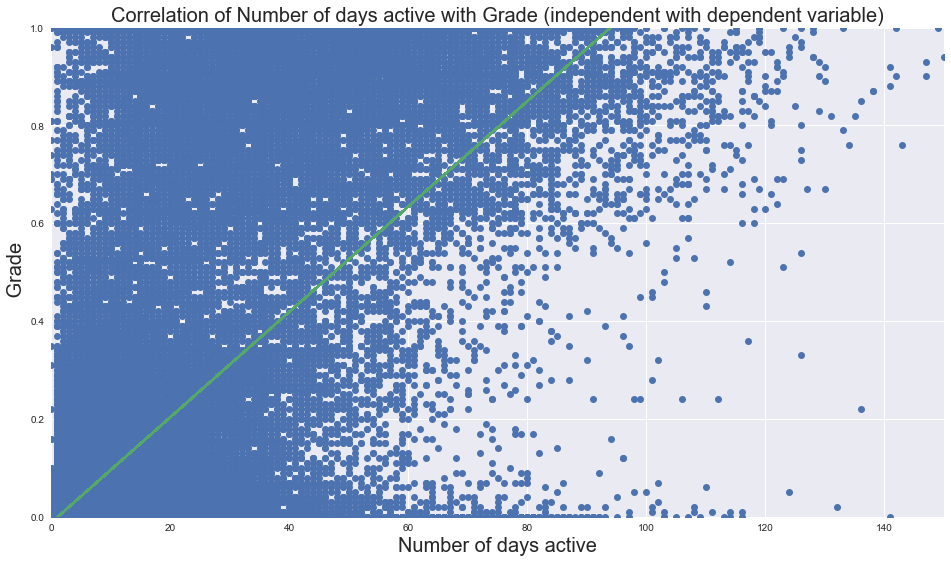

In [54]:
plt.xlabel('Number of days active',  fontname = "Arial", fontsize=20)
plt.ylabel(' Grade',  fontname = "Arial", fontsize=20)
plt.title("Correlation of Number of days active with Grade (independent with dependent variable)",  fontname = "Arial", fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(data['ndays_act'],data['grade'])
#p_r_value, p_p_value = stats.pearsonr(data['ndays_act'],data['grade'])
line = slope* data['ndays_act']+intercept
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_xlim([0,150])

plt.plot(data['ndays_act'],data['grade'],'o', data['ndays_act'], line)
res = pd.DataFrame([[slope, intercept, r_value, p_value, std_err]], columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err'])
res.head()

In [38]:
plt.xlabel('explored')
plt.ylabel(' grade')
slope, intercept, r_value, p_value, std_err = stats.linregress(data['explored'],data['grade'])
# p_r_value, p_p_value = stats.pearsonr(data['explored'],data['grade'])
line = slope* data['explored']+intercept
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_xlim([0,1])

plt.plot(data['explored'],data['grade'],'o', data['explored'], line)
res = pd.DataFrame([[slope, intercept, r_value, p_value, std_err]], columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err'])
res.head()

,slope,intercept,r_value,p_value,std_err
0,0.418314,0.005566,0.692455,0.0,0.00062


OverflowError: In draw_path: Exceeded cell block limit

In [39]:
print('R2:', metrics.r2_score(data['grade'], line))

R2: 0.479494044488


In [40]:
data['explored'].value_counts()

0    464067
1     30723
Name: explored, dtype: int64

,slope,intercept,r_value,p_value,std_err,Pearsons r_value,Pearsons p_value
0,5780.376258,101.532235,0.708108,0.0,8.194374,0.708108,0.0


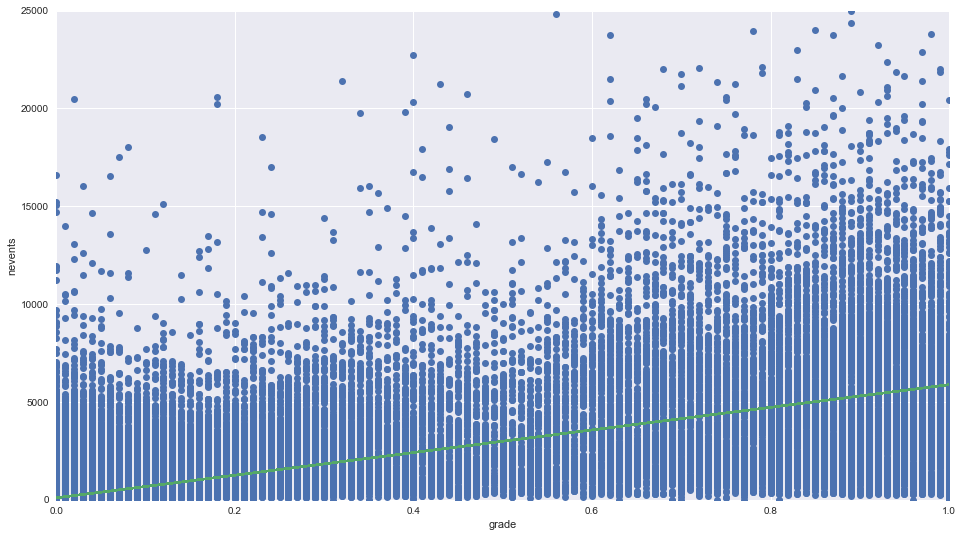

In [41]:
plt.xlabel('grade')
plt.ylabel('nevents')
slope, intercept, r_value, p_value, std_err = stats.linregress(data['grade'],data['nevents'])
p_r_value, p_p_value = stats.pearsonr(data['grade'],data['nevents'])
line = slope* data['grade']+intercept
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,25000])

plt.plot(data['grade'],data['nevents'],'o', data['grade'], line)
res = pd.DataFrame([[slope, intercept, r_value, p_value, std_err, p_r_value, p_p_value]], columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err', 'Pearsons r_value','Pearsons p_value'])
res.head()

,slope,intercept,r_value,p_value,std_err,Pearsons r_value,Pearsons p_value
0,-0.000113,0.035258,-0.006883,0.000001,0.000023,-0.006883,0.000001


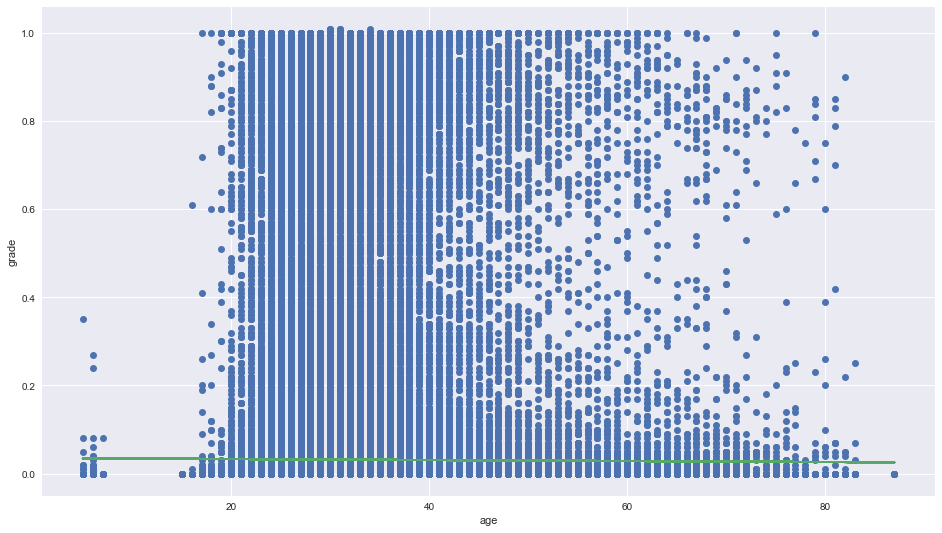

In [42]:
plt.xlabel('age')
plt.ylabel('grade')
slope, intercept, r_value, p_value, std_err = stats.linregress(data['age'],data['grade'])
p_r_value, p_p_value = stats.pearsonr(data['age'],data['grade'])
line = slope* data['age']+intercept
axes = plt.gca()
#axes.set_xlim([0,1])
#axes.set_ylim([15,60])

plt.plot(data['age'],data['grade'],'o')
plt.plot(data['age'], line)
res = pd.DataFrame([[slope, intercept, r_value, p_value, std_err, p_r_value, p_p_value]], columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err', 'Pearsons r_value','Pearsons p_value'])
res.head()

,slope,intercept,r_value,p_value,std_err,Pearsons r_value,Pearsons p_value
0,0.556366,0.607547,0.167548,0.0,0.004654,0.167548,0.0


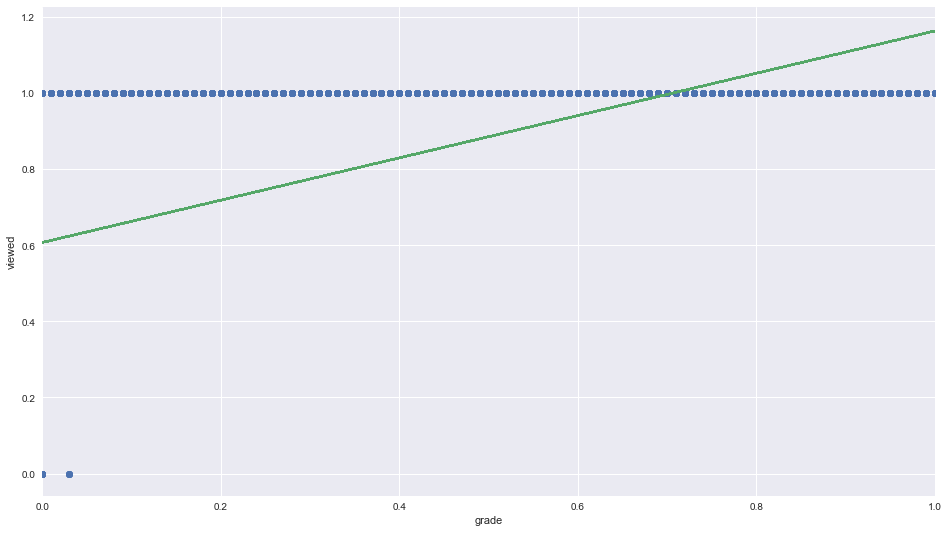

In [43]:
plt.xlabel('grade')
plt.ylabel('viewed')
slope, intercept, r_value, p_value, std_err = stats.linregress(data['grade'],data['viewed'])
p_r_value, p_p_value = stats.pearsonr(data['grade'],data['viewed'])
line = slope* data['grade']+intercept
axes = plt.gca()
axes.set_xlim([0,1])
#axes.set_ylim([15,60])

plt.plot(data['grade'],data['viewed'],'o', data['grade'], line)
res = pd.DataFrame([[slope, intercept, r_value, p_value, std_err, p_r_value, p_p_value]], columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err', 'Pearsons r_value','Pearsons p_value'])
res.head()

In [44]:
data.columns

Index(['course_id', 'userid_DI', 'viewed', 'explored', 'final_cc_cname_DI',
       'LoE_DI', 'YoB', 'gender', 'grade', 'start_time_DI', 'last_event_DI',
       'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts',
       'Australia', 'Bangladesh', 'Brazil', 'Canada', 'China', 'Colombia',
       'Egypt', 'France', 'Germany', 'Greece', 'India', 'Indonesia', 'Japan',
       'Mexico', 'Morocco', 'Nigeria', 'Other Africa', 'Other East Asia',
       'Other Europe', 'Other Middle East/Central Asia',
       'Other North & Central Amer., Caribbean', 'Other Oceania',
       'Other South America', 'Other South Asia', 'Pakistan', 'Philippines',
       'Poland', 'Portugal', 'Russian Federation', 'Spain', 'Ukraine',
       'United Kingdom', 'United States', 'Unknown/Other', 'days_active',
       'Bachelor's', 'Doctorate', 'Less than Secondary', 'Master's',
       'Secondary', 'UnknownLoE', 'f', 'm', 'o', 'u', 'age'],
      dtype='object')

In [45]:
data.to_csv('data_set_cleaned.csv')

In [46]:
#excluded_columns = ['course_id','userid_DI', 'final_cc_cname_DI', 'start_time_DI', 'last_event_DI', 'LoE_DI','YoB', 'gender','grade'] 
#columns that we didn't wanna drop from original data set but are excluded from X input for regression
#because we use their derivatives and columns that are excluded as not needed for regression

In [47]:
data.columns

Index(['course_id', 'userid_DI', 'viewed', 'explored', 'final_cc_cname_DI',
       'LoE_DI', 'YoB', 'gender', 'grade', 'start_time_DI', 'last_event_DI',
       'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts',
       'Australia', 'Bangladesh', 'Brazil', 'Canada', 'China', 'Colombia',
       'Egypt', 'France', 'Germany', 'Greece', 'India', 'Indonesia', 'Japan',
       'Mexico', 'Morocco', 'Nigeria', 'Other Africa', 'Other East Asia',
       'Other Europe', 'Other Middle East/Central Asia',
       'Other North & Central Amer., Caribbean', 'Other Oceania',
       'Other South America', 'Other South Asia', 'Pakistan', 'Philippines',
       'Poland', 'Portugal', 'Russian Federation', 'Spain', 'Ukraine',
       'United Kingdom', 'United States', 'Unknown/Other', 'days_active',
       'Bachelor's', 'Doctorate', 'Less than Secondary', 'Master's',
       'Secondary', 'UnknownLoE', 'f', 'm', 'o', 'u', 'age'],
      dtype='object')

In [48]:
l = []
slope, intercept, r_value, p_value, std_err = stats.linregress(data['grade'],data[''])
l.append(p_value)

KeyError: ''

In [ ]:
l